In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Reshape, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


Loading the data

In [2]:
path_to_normalised_data = "Data/normalised/"
path_to_data = "Data/Train + Test/"

In [3]:
X_train_normalised = np.load(path_to_normalised_data + "X_train_rescaled.npy", allow_pickle=True, mmap_mode="r")
X_test_normalised = np.load(path_to_normalised_data + "X_test_rescaled.npy", allow_pickle=True, mmap_mode="r")
X_val_normalised = np.load(path_to_normalised_data + "X_val_rescaled.npy", allow_pickle=True, mmap_mode="r")

labels_train_normalised = np.load(path_to_normalised_data + "labels_train_normalised.npy", allow_pickle=True, mmap_mode="r")
labels_test_normalised = np.load(path_to_normalised_data + "labels_test_normalised.npy", allow_pickle=True, mmap_mode="r")
labels_val_normalised = np.load(path_to_normalised_data + "labels_val_normalised.npy", allow_pickle=True, mmap_mode="r")

common_time_train = np.load("Data/Train + Test/common_time_train.npy", allow_pickle=True).astype(datetime.datetime)
common_time_test = np.load("Data/Train + Test/common_time_test.npy", allow_pickle=True).astype(datetime.datetime)
common_time_val = np.load("Data/Train + Test/common_time_val.npy", allow_pickle=True).astype(datetime.datetime)

ground_truth_train = np.load("Data/Train + Test/ground_truth_train.npy", allow_pickle=True, mmap_mode="r")
ground_truth_test = np.load("Data/Train + Test/ground_truth_test.npy", allow_pickle=True, mmap_mode="r")
ground_truth_val = np.load("Data/Train + Test/ground_truth_val.npy", allow_pickle=True, mmap_mode="r")

num_train_samples = X_train_normalised.shape[0]
num_test_samples = X_test_normalised.shape[0]
num_val_samples = X_val_normalised.shape[0]

print(X_train_normalised.shape)
print(X_test_normalised.shape)
print(X_val_normalised.shape)




(3000, 2, 62, 62, 3)
(500, 2, 62, 62, 3)
(500, 2, 62, 62, 3)


Example of scaling down the images

(250, 250, 3)
(62, 62, 3)


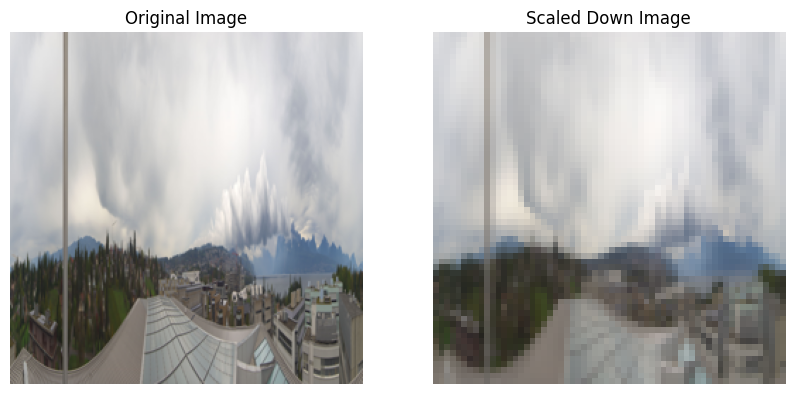

In [4]:
import matplotlib.pyplot as plt
from skimage.transform import rescale

X_BC = np.load(path_to_data + "X_BC_train.npy", allow_pickle=True, mmap_mode="r")

# Assuming X_train_normalised is already loaded and contains image data
first_image = X_BC[0]
print(first_image.shape)

# Display the first image
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(first_image)
plt.title('Original Image')
plt.axis('off')

# Rescale the image to 50% of its original size
scaled_image = rescale(first_image, 0.25, anti_aliasing=True, channel_axis=-1)
print(scaled_image.shape)

# Display the rescaled image
plt.subplot(1, 2, 2)
plt.imshow(scaled_image, cmap='gray')
plt.title('Scaled Down Image')
plt.axis('off')

plt.show()


Model Architecture

In [8]:
input_sequence1 = tf.keras.layers.Input(shape=(2, 62, 62, 3))

# CNN block 1
first_input = TimeDistributed(Conv2D(8, kernel_size=3, activation='relu'))(input_sequence1)
first_input = TimeDistributed(MaxPooling2D(pool_size=2))(first_input)
first_input = TimeDistributed(Conv2D(8, kernel_size=3, activation='relu'))(first_input)
first_input = TimeDistributed(MaxPooling2D(pool_size=2))(first_input)

# CNN block 2
first_input = TimeDistributed(Conv2D(16, kernel_size=3, activation='relu'))(first_input)
first_input = TimeDistributed(MaxPooling2D(pool_size=2))(first_input)
first_input = TimeDistributed(Conv2D(16, kernel_size=3, activation='relu'))(first_input)
first_input = TimeDistributed(MaxPooling2D(pool_size=2))(first_input)

# Flatten and reshape for LSTM
flt = TimeDistributed(Flatten())(first_input)
flt = Reshape((1,-1))(flt)

# LSTM
# lstm1 = LSTM(units = 16, activation='relu', return_sequences=True)(flt)
# lstm2 = LSTM(units=16, activation='relu', return_sequences=True)(lstm1)
# lstm3 = LSTM(units=16, activation='relu', return_sequences=False)(lstm2)

lstm1 = LSTM(units = 8, activation='relu', return_sequences=False)(flt)

# Output layer
dense1 =Dense(1, activation='relu')(lstm1)

# Create the model
model = Model(inputs=input_sequence1, outputs=dense1)


# compile the model
opt =tf.keras.optimizers.Adam(learning_rate = 1e-3)  #default is 1e-3,
model.compile(optimizer=opt, loss='mean_squared_error',)

# history
history = model.fit(X_train_normalised, labels_train_normalised[-num_train_samples:], epochs=10,  validation_data=(X_val_normalised, labels_val_normalised[:num_val_samples]))

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.1297 - val_loss: 0.1010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0329 - val_loss: 0.1398
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0218 - val_loss: 0.1210
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0227 - val_loss: 0.1231
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0212 - val_loss: 0.1243
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0193 - val_loss: 0.1291
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0198 - val_loss: 0.1346
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0174 - val_loss: 0.1226
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0195 - val_loss: 0.1188
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0181 - val_loss: 0.1382


Looking at the training data

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
(3000, 1)


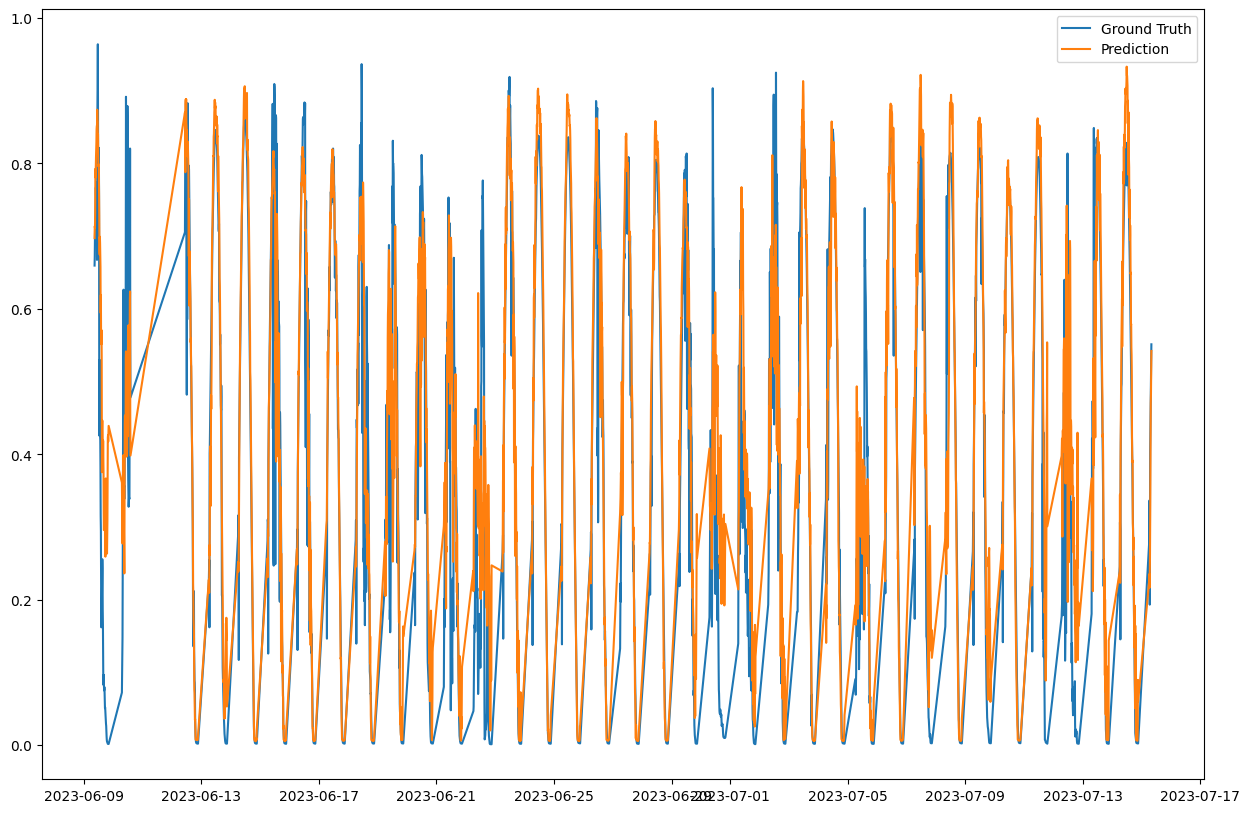

In [11]:
predictions1 = model.predict(X_train_normalised)

print(predictions1.shape)

# Plot the predictions
plt.figure(figsize=(15, 10))
plt.plot(common_time_train[-num_train_samples:], labels_train_normalised[-num_train_samples:], label='Ground Truth')
#predictions1_plot = np.squeeze(predictions1, axis=(1, 2))
plt.plot(common_time_train[-num_train_samples:], predictions1, label='Prediction')
plt.legend()
plt.show()

Looking at the test data

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(500, 1)


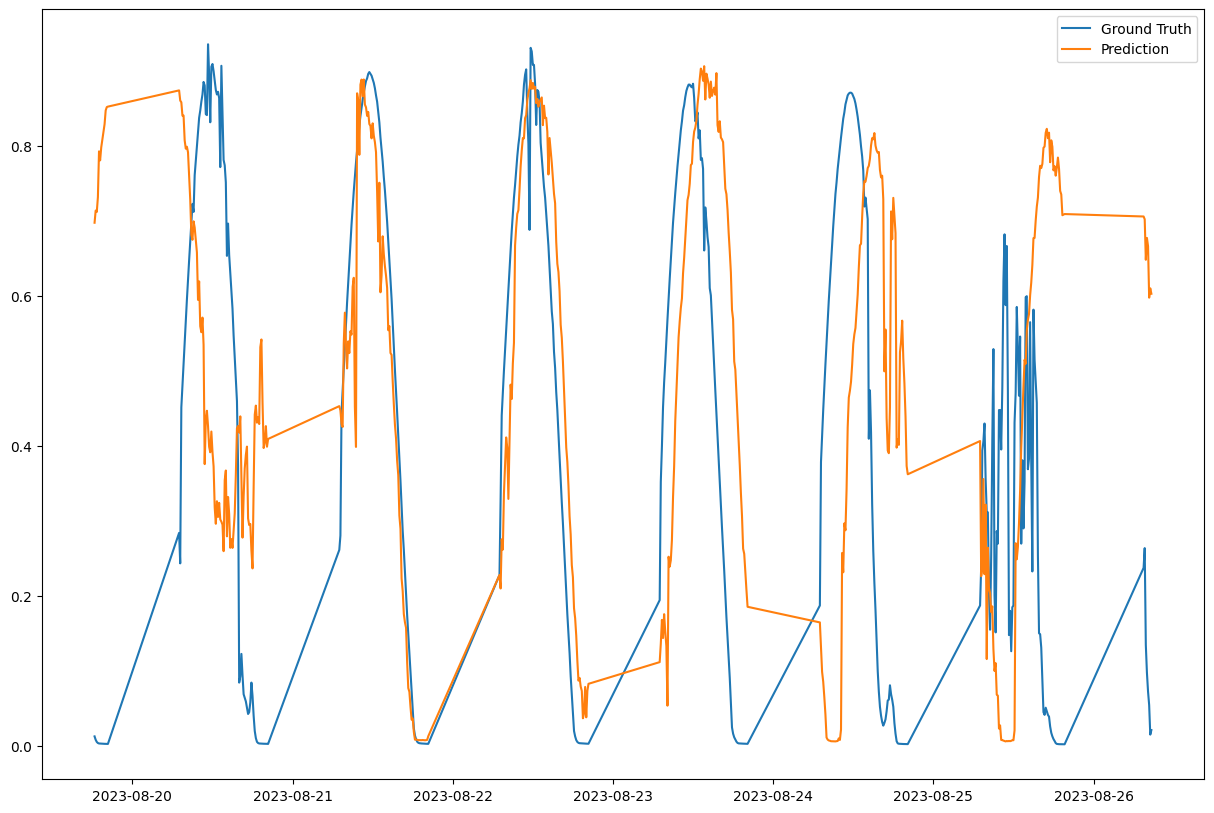

In [12]:
predictions1 = model.predict(X_test_normalised)

print(predictions1.shape)

# Plot the predictions
plt.figure(figsize=(15, 10))
plt.plot(common_time_test[:num_test_samples], labels_test_normalised[:num_test_samples], label='Ground Truth')
#predictions1_plot = np.squeeze(predictions1, axis=(1, 2))
plt.plot(common_time_test[:num_test_samples], predictions1, label='Prediction')
plt.legend()
plt.show()